# Image Classification using CNN for MircoImageNet dataset

### Getting dataset from stanford website and importing required libraries

In [ ]:
# Downloading and unzipping the tiny imagenet-200 dataset

!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip &> /dev/null
!unzip tiny-imagenet-200.zip &> /dev/null

In [ ]:
# Importing requires libraries
import os
import cv2
import keras
import numpy as np
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras import losses
from keras.preprocessing.image import ImageDataGenerator,image, image_dataset_from_directory
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPool2D
from keras.callbacks import ModelCheckpoint
import pickle

In [ ]:
# Copying dataset to google drive for safety
# !cp "/content/tiny-imagenet-200.zip" -r "/content/gdrive/MyDrive/dlproject"

### As the dataset is too large we need to use data generator for training tha model.
### For training the data using Data generator, Images must  be formatted in the below format:
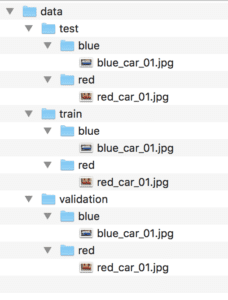


In [ ]:
import os
# Define main data directory
DATA_DIR = 'tiny-imagenet-200' # Original images come in shapes of [64,64,3]

# Define training and validation data paths
TRAIN_DIR = os.path.join(DATA_DIR, 'train') 
VALID_DIR = os.path.join(DATA_DIR, 'val')
TEST_DIR = os.path.join(DATA_DIR, 'test')

In [ ]:
# Creating dictionary object containing folder names and corresponding labels

file = open(DATA_DIR + "/words.txt")
FOLDER_LABEL_DICT = {}
count = 0
for row in file:
  folder_name = row[0:9]
  label = row[10:-1].split(",")[0]
  label = label.replace(" ", "_", -1)
  # print(folder_name , " ", label)
  count+=1
  FOLDER_LABEL_DICT[folder_name] = label
file.close()

print(count)
print(len(FOLDER_LABEL_DICT))
# print(FOLDER_LABEL_DICT)

82115
82115


In [ ]:
# renaming all train data folder names to corresponding labels

# shutil for deleting non empty folders
import shutil

for folder_name in os.listdir(TRAIN_DIR):
  if os.path.isdir(TRAIN_DIR + "/" + folder_name + "/images"):
    label = FOLDER_LABEL_DICT[folder_name]
    os.rename(TRAIN_DIR + "/" + folder_name + "/images",
              TRAIN_DIR + "/" + label)
    shutil.rmtree(TRAIN_DIR + "/" + folder_name)

In [ ]:
# Rearranging all the validation set images to corresponding format

file = open(VALID_DIR + "/val_annotations.txt")
for line in file:
  line = line[:-1].split("\t")
  img, label = line[0], line[1]
  label = FOLDER_LABEL_DICT[label]
  # print(label)
  os.makedirs(VALID_DIR + "/" + label, exist_ok=True)
  os.rename(VALID_DIR + "/images/" + img,
            VALID_DIR + "/" + label + "/" + img)
shutil.rmtree(VALID_DIR + "/images")
file.close()

In [ ]:
# Data Generator

datagen = ImageDataGenerator(rotation_range=20,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             rescale=1./255, 
                             zoom_range=0.2,
                             horizontal_flip = True,
                             vertical_flip = False)

train_it = datagen.flow_from_directory(directory = TRAIN_DIR,
                                        # classes='inferred',
                                        class_mode='categorical',
                                        color_mode="rgb",
                                        batch_size=64,
                                        target_size=(64, 64),
                                        shuffle=True,
                                        seed=101)

label_map = (train_it.class_indices)
labels = list(label_map.keys())

validation_it = datagen.flow_from_directory(directory = VALID_DIR,
                                        # classes='inferred',
                                        class_mode='categorical',
                                        color_mode="rgb",
                                        batch_size=64,
                                        target_size=(64, 64),
                                        shuffle=True,
                                        seed=101)

Found 100000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.


In [ ]:
# saving model to Google Drive for every epoch (Backup)

from google.colab import drive
drive._mount('/content/gdrive')

Mounted at /content/gdrive


### Building a CNN model similar to VGG-16 architecture

In [ ]:
# Building model similar to VGG-16 architecture
def create_model():
  model = Sequential()

  model.add(Conv2D(input_shape=(64,64,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
  model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

  model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

  model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

  # model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  # model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  # model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  # model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

  model.add(Flatten())
  model.add(Dense(units=4096,activation="relu"))
  model.add(Dense(units=4096,activation="relu"))
  model.add(Dense(units=200, activation="softmax"))
  return model

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 64, 64, 64)        1792      
                                                                 
 conv2d_29 (Conv2D)          (None, 64, 64, 64)        36928     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 32, 32, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_30 (Conv2D)          (None, 32, 32, 128)       73856     
                                                                 
 conv2d_31 (Conv2D)          (None, 32, 32, 128)       147584    
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 16, 16, 128)      0         
 g2D)                                                 

In [ ]:
# Example for compiling the sequential model

opt = tf.keras.optimizers.Adam(learning_rate=0.00001)

model.compile(loss = 'categorical_crossentropy',
              metrics=['accuracy'],
              optimizer= opt)

#### Checkpoints

In [ ]:
# Example for callbacks for saving our trained model period
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("vgg16_.h5",
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=False,
                             mode='auto',
                             period=1)

### Finding optimal learning rate
#### Here we training our model for 6 different learning rates i.e 
#### [0.01, 0.001, 0.0001, 0.00001, 0.000001, 0.0000001]

In [ ]:
# lr = 0.01
model = create_model()
model.compile(loss = 'categorical_crossentropy',
              metrics=['accuracy'],
              optimizer= Adam(learning_rate= 0.01))


checkpoint = ModelCheckpoint("/content/gdrive/MyDrive/dlproject/learningrate/vgg16_01.h5",
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=False,
                             mode='auto',
                             period=1)

lr01 = model.fit(train_it,batch_size=64,
                validation_data= validation_it,
                epochs=10,
                verbose=1,
                 callbacks=[checkpoint])

# Open a file and use dump()
with open('/content/gdrive/MyDrive/dlproject/learningrate/history01.pkl', 'wb') as file:
      
    # A new file will be created
    pickle.dump(lr01, file)

Epoch 1/10
1563/1563 [==============================] - ETA: 0s - loss: 17580.8359 - accuracy: 0.0050
Epoch 00001: val_accuracy improved from -inf to 0.00500, saving model to /content/gdrive/MyDrive/dlproject/learningrate/vgg16_01.h5
1563/1563 [==============================] - 289s 184ms/step - loss: 17580.8359 - accuracy: 0.0050 - val_loss: 5.3016 - val_accuracy: 0.0050
Epoch 2/10
1563/1563 [==============================] - ETA: 0s - loss: 5.3036 - accuracy: 0.0047
Epoch 00002: val_accuracy did not improve from 0.00500
1563/1563 [==============================] - 288s 184ms/step - loss: 5.3036 - accuracy: 0.0047 - val_loss: 5.3014 - val_accuracy: 0.0050
Epoch 3/10
1563/1563 [==============================] - ETA: 0s - loss: 5.3033 - accuracy: 0.0046
Epoch 00003: val_accuracy did not improve from 0.00500
1563/1563 [==============================] - 284s 182ms/step - loss: 5.3033 - accuracy: 0.0046 - val_loss: 5.3013 - val_accuracy: 0.0050
Epoch 4/10
1563/1563 [=======================

In [ ]:
# lr = 0.001
model = create_model()
model.compile(loss = 'categorical_crossentropy',
              metrics=['accuracy'],
              optimizer= Adam(learning_rate= 0.001))


checkpoint = ModelCheckpoint("/content/gdrive/MyDrive/dlproject/learningrate/vgg16_001.h5",
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=False,
                             mode='auto',
                             period=1)

lr001 = model.fit(train_it,batch_size=64,
                validation_data= validation_it,
                epochs=10,
                verbose=1,
                callbacks=[checkpoint])

# Open a file and use dump()
with open('/content/gdrive/MyDrive/dlproject/learningrate/history001.pkl', 'wb') as file:
      
    # A new file will be created
    pickle.dump(lr001, file)

Epoch 1/10
1563/1563 [==============================] - ETA: 0s - loss: 5.2992 - accuracy: 0.0044
Epoch 00001: val_accuracy improved from -inf to 0.00500, saving model to /content/gdrive/MyDrive/dlproject/learningrate/vgg16_001.h5
1563/1563 [==============================] - 325s 187ms/step - loss: 5.2992 - accuracy: 0.0044 - val_loss: 5.2983 - val_accuracy: 0.0050
Epoch 2/10
1563/1563 [==============================] - ETA: 0s - loss: 5.2991 - accuracy: 0.0047
Epoch 00002: val_accuracy did not improve from 0.00500
1563/1563 [==============================] - 289s 185ms/step - loss: 5.2991 - accuracy: 0.0047 - val_loss: 5.2983 - val_accuracy: 0.0050
Epoch 3/10
1563/1563 [==============================] - ETA: 0s - loss: 5.2991 - accuracy: 0.0044
Epoch 00003: val_accuracy did not improve from 0.00500
1563/1563 [==============================] - 288s 184ms/step - loss: 5.2991 - accuracy: 0.0044 - val_loss: 5.2983 - val_accuracy: 0.0050
Epoch 4/10
1563/1563 [==============================

In [ ]:
# lr = 0.0001
model = create_model()
model.compile(loss = 'categorical_crossentropy',
              metrics=['accuracy'],
              optimizer= Adam(learning_rate= 0.0001))


checkpoint = ModelCheckpoint("/content/gdrive/MyDrive/dlproject/learningrate/vgg16_0001.h5",
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=False,
                             mode='auto',
                             period=1)

lr0001 = model.fit(train_it,batch_size=64,
                validation_data= validation_it,
                epochs=10,
                verbose=1,
                 callbacks=[checkpoint])

# Open a file and use dump()
with open('/content/gdrive/MyDrive/dlproject/learningrate/history0001.pkl', 'wb') as file:
      
    # A new file will be created
    pickle.dump(lr0001, file)

Epoch 1/10
1563/1563 [==============================] - ETA: 0s - loss: 5.2985 - accuracy: 0.0040
Epoch 00001: val_accuracy improved from -inf to 0.00500, saving model to /content/gdrive/MyDrive/dlproject/learningrate/vgg16_0001.h5
1563/1563 [==============================] - 299s 190ms/step - loss: 5.2985 - accuracy: 0.0040 - val_loss: 5.2983 - val_accuracy: 0.0050
Epoch 2/10
1563/1563 [==============================] - ETA: 0s - loss: 5.2984 - accuracy: 0.0044
Epoch 00002: val_accuracy did not improve from 0.00500
1563/1563 [==============================] - 296s 189ms/step - loss: 5.2984 - accuracy: 0.0044 - val_loss: 5.2983 - val_accuracy: 0.0050
Epoch 3/10
1563/1563 [==============================] - ETA: 0s - loss: 5.2984 - accuracy: 0.0043
Epoch 00003: val_accuracy did not improve from 0.00500
1563/1563 [==============================] - 293s 187ms/step - loss: 5.2984 - accuracy: 0.0043 - val_loss: 5.2983 - val_accuracy: 0.0050
Epoch 4/10
1563/1563 [=============================

In [ ]:
# lr = 0.00001
model = create_model()
model.compile(loss = 'categorical_crossentropy',
              metrics=['accuracy'],
              optimizer= Adam(learning_rate= 0.00001))


checkpoint = ModelCheckpoint("/content/gdrive/MyDrive/dlproject/learningrate/vgg16_00001.h5",
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=False,
                             mode='auto',
                             period=1)

lr00001 = model.fit(train_it,batch_size=64,
                validation_data= validation_it,
                epochs=10,
                verbose=1,
                 callbacks=[checkpoint])

# Open a file and use dump()
with open('/content/gdrive/MyDrive/dlproject/learningrate/history00001.pkl', 'wb') as file:
      
    # A new file will be created
    pickle.dump(lr00001, file)

Epoch 1/10
1563/1563 [==============================] - ETA: 0s - loss: 5.0658 - accuracy: 0.0201
Epoch 00001: val_accuracy improved from -inf to 0.03470, saving model to /content/gdrive/MyDrive/dlproject/learningrate/vgg16_00001.h5
1563/1563 [==============================] - 301s 192ms/step - loss: 5.0658 - accuracy: 0.0201 - val_loss: 4.9066 - val_accuracy: 0.0347
Epoch 2/10
1563/1563 [==============================] - ETA: 0s - loss: 4.7446 - accuracy: 0.0538
Epoch 00002: val_accuracy improved from 0.03470 to 0.06880, saving model to /content/gdrive/MyDrive/dlproject/learningrate/vgg16_00001.h5
1563/1563 [==============================] - 306s 196ms/step - loss: 4.7446 - accuracy: 0.0538 - val_loss: 4.5949 - val_accuracy: 0.0688
Epoch 3/10
1563/1563 [==============================] - ETA: 0s - loss: 4.4528 - accuracy: 0.0902
Epoch 00003: val_accuracy improved from 0.06880 to 0.09840, saving model to /content/gdrive/MyDrive/dlproject/learningrate/vgg16_00001.h5
1563/1563 [==========

In [ ]:
# lr = 0.000001
model = create_model()
model.compile(loss = 'categorical_crossentropy',
              metrics=['accuracy'],
              optimizer= Adam(learning_rate= 0.000001))


checkpoint = ModelCheckpoint("/content/gdrive/MyDrive/dlproject/learningrate/vgg16_000001.h5",
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=False,
                             mode='auto',
                             period=1)

lr000001 = model.fit(train_it,batch_size=64,
                validation_data= validation_it,
                epochs=10,
                verbose=1,
                 callbacks=[checkpoint])

# Open a file and use dump()
with open('/content/gdrive/MyDrive/dlproject/learningrate/history000001.pkl', 'wb') as file:
      
    # A new file will be created
    pickle.dump(lr000001, file)

Epoch 1/10
1563/1563 [==============================] - ETA: 0s - loss: 5.2682 - accuracy: 0.0098
Epoch 00001: val_accuracy improved from -inf to 0.01690, saving model to /content/gdrive/MyDrive/dlproject/learningrate/vgg16_000001.h5
1563/1563 [==============================] - 300s 191ms/step - loss: 5.2682 - accuracy: 0.0098 - val_loss: 5.1109 - val_accuracy: 0.0169
Epoch 2/10
1563/1563 [==============================] - ETA: 0s - loss: 5.0548 - accuracy: 0.0225
Epoch 00002: val_accuracy improved from 0.01690 to 0.02440, saving model to /content/gdrive/MyDrive/dlproject/learningrate/vgg16_000001.h5
1563/1563 [==============================] - 303s 194ms/step - loss: 5.0548 - accuracy: 0.0225 - val_loss: 5.0203 - val_accuracy: 0.0244
Epoch 3/10
1563/1563 [==============================] - ETA: 0s - loss: 5.0060 - accuracy: 0.0280
Epoch 00003: val_accuracy improved from 0.02440 to 0.02740, saving model to /content/gdrive/MyDrive/dlproject/learningrate/vgg16_000001.h5
1563/1563 [=======

In [ ]:
# lr = 0.0000001
model = create_model()
model.compile(loss = 'categorical_crossentropy',
              metrics=['accuracy'],
              optimizer= Adam(learning_rate= 0.0000001))


checkpoint = ModelCheckpoint("/content/gdrive/MyDrive/dlproject/learningrate/vgg16_000001.h5",
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=False,
                             mode='auto',
                             period=1)

lr0000001 = model.fit(train_it,batch_size=64,
                validation_data= validation_it,
                epochs=10,
                verbose=1,
                 callbacks=[checkpoint])

# Open a file and use dump()
with open('/content/gdrive/MyDrive/dlproject/learningrate/history0000001.pkl', 'wb') as file:
      
    # A new file will be created
    pickle.dump(lr0000001, file)

Epoch 1/10
1563/1563 [==============================] - ETA: 0s - loss: 5.2983 - accuracy: 0.0055
Epoch 00001: val_accuracy improved from -inf to 0.00500, saving model to /content/gdrive/MyDrive/dlproject/learningrate/vgg16_000001.h5
1563/1563 [==============================] - 367s 214ms/step - loss: 5.2983 - accuracy: 0.0055 - val_loss: 5.2982 - val_accuracy: 0.0050
Epoch 2/10
1563/1563 [==============================] - ETA: 0s - loss: 5.2981 - accuracy: 0.0052
Epoch 00002: val_accuracy did not improve from 0.00500
1563/1563 [==============================] - 287s 184ms/step - loss: 5.2981 - accuracy: 0.0052 - val_loss: 5.2981 - val_accuracy: 0.0047
Epoch 3/10
1563/1563 [==============================] - ETA: 0s - loss: 5.2980 - accuracy: 0.0053
Epoch 00003: val_accuracy improved from 0.00500 to 0.00560, saving model to /content/gdrive/MyDrive/dlproject/learningrate/vgg16_000001.h5
1563/1563 [==============================] - 311s 199ms/step - loss: 5.2980 - accuracy: 0.0053 - val_l

#### Results

In [ ]:
# saving model to Google Drive for every epoch (Backup)

from google.colab import drive
drive._mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Importing trained models from google drive
import pickle

with open("/content/gdrive/MyDrive/dlproject/learningrate/history01.pkl",'rb') as file:
  hist01 = pickle.load(file)

with open("/content/gdrive/MyDrive/dlproject/learningrate/history001.pkl",'rb') as file:
  hist001 = pickle.load(file)

with open("/content/gdrive/MyDrive/dlproject/learningrate/history0001.pkl",'rb') as file:
  hist0001 = pickle.load(file)

with open("/content/gdrive/MyDrive/dlproject/learningrate/history00001.pkl",'rb') as file:
  hist00001 = pickle.load(file)

with open("/content/gdrive/MyDrive/dlproject/learningrate/history000001.pkl",'rb') as file:
  hist000001 = pickle.load(file)

with open("/content/gdrive/MyDrive/dlproject/learningrate/history0000001.pkl",'rb') as file:
  hist0000001 = pickle.load(file)


In [ ]:
lr_01 = hist01.history['val_accuracy']
lr_001 = hist001.history['val_accuracy']
lr_0001 = hist0001.history['val_accuracy']
lr_00001 = hist00001.history['val_accuracy']
lr_000001 = hist000001.history['val_accuracy']
lr_0000001 = hist0000001.history['val_accuracy']

##### Validation Accuracy VS Epochs

[Text(0, 0.5, 'Validation Accuracy'), Text(0.5, 0, 'Epochs')]

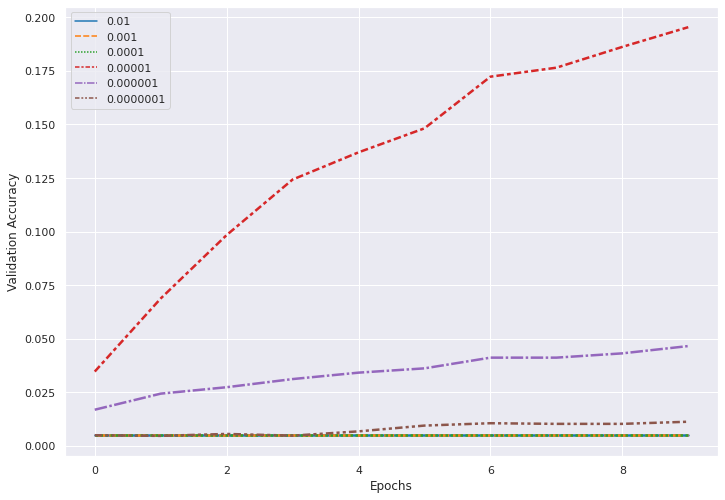

In [ ]:
import seaborn as sns
import pandas as pd
data = pd.DataFrame({'0.01' : lr_01, '0.001': lr_001, '0.0001': lr_0001, '0.00001' : lr_00001, '0.000001':lr_000001, '0.0000001':lr_0000001}, index = range(0,10,1))
# data
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(data = data, palette='tab10',linewidth=2.5).set(xlabel = 'Epochs', ylabel = 'Validation Accuracy', )

###### From the above plot we can choose learning rate as 0.00001 

### FINDING OPTIMAL OPTIMIZER

#### Here we training our model for 4 different optimizers i.e 
#### [SGD with momentum, Adagrad, RMSProp, Adam]

In [ ]:
# Optimizer = SGD + momentum
model = create_model()
model.compile(loss = 'categorical_crossentropy',
              metrics=['accuracy'],
              optimizer= tf.keras.optimizers.SGD(learning_rate= 0.00001, momentum= 0.9))


checkpoint = ModelCheckpoint("/content/gdrive/MyDrive/dlproject/optimizers/vgg16_sgdmomen.h5",
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=False,
                             mode='auto',
                             period=1)

lrsgdmomen = model.fit(train_it,batch_size=64,
                validation_data= validation_it,
                epochs=10,
                verbose=1,
                 callbacks=[checkpoint])

# Open a file and use dump()
with open('/content/gdrive/MyDrive/dlproject/optimizers/historysgdmomen.pkl', 'wb') as file:
      
    # A new file will be created
    pickle.dump(lrsgdmomen, file)

Epoch 1/10
1563/1563 [==============================] - ETA: 0s - loss: 5.2983 - accuracy: 0.0050
Epoch 00001: val_accuracy improved from -inf to 0.00510, saving model to /content/gdrive/MyDrive/dlproject/optimizers/vgg16_sgdmomen.h5
1563/1563 [==============================] - 292s 186ms/step - loss: 5.2983 - accuracy: 0.0050 - val_loss: 5.2983 - val_accuracy: 0.0051
Epoch 2/10
1563/1563 [==============================] - ETA: 0s - loss: 5.2983 - accuracy: 0.0050
Epoch 00002: val_accuracy did not improve from 0.00510
1563/1563 [==============================] - 286s 183ms/step - loss: 5.2983 - accuracy: 0.0050 - val_loss: 5.2983 - val_accuracy: 0.0050
Epoch 3/10
1563/1563 [==============================] - ETA: 0s - loss: 5.2983 - accuracy: 0.0050
Epoch 00003: val_accuracy did not improve from 0.00510
1563/1563 [==============================] - 285s 182ms/step - loss: 5.2983 - accuracy: 0.0050 - val_loss: 5.2983 - val_accuracy: 0.0050
Epoch 4/10
1563/1563 [===========================

In [ ]:
# Optimizer = Adagrad
model = create_model()
model.compile(loss = 'categorical_crossentropy',
              metrics=['accuracy'],
              optimizer= tf.keras.optimizers.Adagrad(learning_rate= 0.00001))


checkpoint = ModelCheckpoint("/content/gdrive/MyDrive/dlproject/optimizers/vgg16_adagrad.h5",
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=False,
                             mode='auto',
                             period=1)

lradagrad = model.fit(train_it,batch_size=64,
                validation_data= validation_it,
                epochs=10,
                verbose=1,
                 callbacks=[checkpoint])

# Open a file and use dump()
with open('/content/gdrive/MyDrive/dlproject/optimizers/historyadagrad.pkl', 'wb') as file:
      
    # A new file will be created
    pickle.dump(lradagrad, file)

Epoch 1/10
1563/1563 [==============================] - ETA: 0s - loss: 5.2983 - accuracy: 0.0049
Epoch 00001: val_accuracy improved from -inf to 0.00420, saving model to /content/gdrive/MyDrive/dlproject/optimizers/vgg16_adagrad.h5
1563/1563 [==============================] - 298s 190ms/step - loss: 5.2983 - accuracy: 0.0049 - val_loss: 5.2983 - val_accuracy: 0.0042
Epoch 2/10
1563/1563 [==============================] - ETA: 0s - loss: 5.2983 - accuracy: 0.0048
Epoch 00002: val_accuracy improved from 0.00420 to 0.00490, saving model to /content/gdrive/MyDrive/dlproject/optimizers/vgg16_adagrad.h5
1563/1563 [==============================] - 299s 191ms/step - loss: 5.2983 - accuracy: 0.0048 - val_loss: 5.2983 - val_accuracy: 0.0049
Epoch 3/10
1563/1563 [==============================] - ETA: 0s - loss: 5.2983 - accuracy: 0.0049
Epoch 00003: val_accuracy improved from 0.00490 to 0.00520, saving model to /content/gdrive/MyDrive/dlproject/optimizers/vgg16_adagrad.h5
1563/1563 [==========

In [ ]:
# Optimizer = RMSProp
model = create_model()
model.compile(loss = 'categorical_crossentropy',
              metrics=['accuracy'],
              optimizer= tf.keras.optimizers.RMSprop(learning_rate= 0.00001))


checkpoint = ModelCheckpoint("/content/gdrive/MyDrive/dlproject/optimizers/vgg16_RMSProp.h5",
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=False,
                             mode='auto',
                             period=1)

lrRMSProp = model.fit(train_it,batch_size=64,
                validation_data= validation_it,
                epochs=10,
                verbose=1,
                 callbacks=[checkpoint])

# Open a file and use dump()
with open('/content/gdrive/MyDrive/dlproject/optimizers/historyRMSProp.pkl', 'wb') as file:
      
    # A new file will be created
    pickle.dump(lrRMSProp, file)

Epoch 1/10
1563/1563 [==============================] - ETA: 0s - loss: 5.0993 - accuracy: 0.0173
Epoch 00001: val_accuracy improved from -inf to 0.02990, saving model to /content/gdrive/MyDrive/dlproject/optimizers/vgg16_RMSProp.h5
1563/1563 [==============================] - 342s 209ms/step - loss: 5.0993 - accuracy: 0.0173 - val_loss: 4.9715 - val_accuracy: 0.0299
Epoch 2/10
1563/1563 [==============================] - ETA: 0s - loss: 4.8809 - accuracy: 0.0394
Epoch 00002: val_accuracy improved from 0.02990 to 0.05080, saving model to /content/gdrive/MyDrive/dlproject/optimizers/vgg16_RMSProp.h5
1563/1563 [==============================] - 323s 206ms/step - loss: 4.8809 - accuracy: 0.0394 - val_loss: 4.7805 - val_accuracy: 0.0508
Epoch 3/10
1563/1563 [==============================] - ETA: 0s - loss: 4.6485 - accuracy: 0.0664
Epoch 00003: val_accuracy improved from 0.05080 to 0.07480, saving model to /content/gdrive/MyDrive/dlproject/optimizers/vgg16_RMSProp.h5
1563/1563 [==========

#### Results

In [ ]:
# Importing trained model from google drive

import pickle

with open("/content/gdrive/MyDrive/dlproject/learningrate/history00001.pkl",'rb') as file:
  adam = pickle.load(file)

with open("/content/gdrive/MyDrive/dlproject/optimizers/historysgdmomen.pkl",'rb') as file:
  sgdmomen = pickle.load(file)

with open("/content/gdrive/MyDrive/dlproject/optimizers/historyadagrad.pkl",'rb') as file:
  adagrad = pickle.load(file)

with open("/content/gdrive/MyDrive/dlproject/optimizers/historyRMSProp.pkl",'rb') as file:
  rmsprop = pickle.load(file)

In [ ]:
adam = adam.history['val_accuracy']
sgdmomen = sgdmomen.history['val_accuracy']
adagrad = adagrad.history['val_accuracy']
rmsprop = rmsprop.history['val_accuracy']

[Text(0, 0.5, 'Validation Accuracy'), Text(0.5, 0, 'Epochs')]

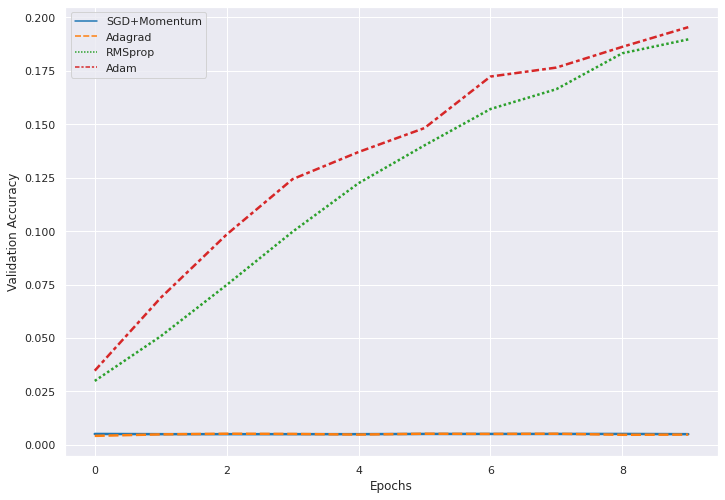

In [ ]:
import seaborn as sns
import pandas as pd
data = pd.DataFrame({'SGD+Momentum' : sgdmomen, 'Adagrad': adagrad, 'RMSprop': rmsprop, 'Adam' : adam}, index = range(0,10,1))
# data
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(data = data, palette='tab10',linewidth=2.5).set(xlabel = 'Epochs', ylabel = 'Validation Accuracy', )

##### From the above plot we can observe that Adam and RMSProp performed well. Lets proceed with Adam

### Training model using Adam optimizer with learning rate = 0.00004

In [ ]:
# importing model trained for learning rate

from tensorflow.keras.models import load_model

model = load_model("/content/gdrive/MyDrive/dlproject/learningrate/vgg16_00001.h5")

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 64, 64, 64)        1792      
                                                                 
 conv2d_21 (Conv2D)          (None, 64, 64, 64)        36928     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_22 (Conv2D)          (None, 32, 32, 128)       73856     
                                                                 
 conv2d_23 (Conv2D)          (None, 32, 32, 128)       147584    
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 16, 16, 128)      0         
 2D)                                                  

In [ ]:
# Training for 10 more epochs
model.compile(loss = 'categorical_crossentropy',
              metrics=['accuracy'],
              optimizer= Adam(learning_rate= 0.00001))


checkpoint = ModelCheckpoint("/content/gdrive/MyDrive/dlproject/training/10_20/model-{epoch:02d}-{val_accuracy:.3f}.hdf5",
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=False,
                             mode='auto',
                             period=1,
                             )

model11_20 = model.fit(train_it,batch_size=64,
                validation_data= validation_it,
                epochs=10,
                verbose=1,
                 callbacks=[checkpoint])

# Open a file and use dump()
with open('/content/gdrive/MyDrive/dlproject/training/10_20/history0000001.pkl', 'wb') as file:
      
    # A new file will be created
    pickle.dump(model11_20, file)

Epoch 1/10
1563/1563 [==============================] - ETA: 0s - loss: 3.4081 - accuracy: 0.2441
Epoch 00001: val_accuracy improved from -inf to 0.20130, saving model to /content/gdrive/MyDrive/dlproject/training/10_20/model-01-0.201.hdf5
1563/1563 [==============================] - 312s 192ms/step - loss: 3.4081 - accuracy: 0.2441 - val_loss: 3.7075 - val_accuracy: 0.2013
Epoch 2/10
1563/1563 [==============================] - ETA: 0s - loss: 3.3140 - accuracy: 0.2603
Epoch 00002: val_accuracy improved from 0.20130 to 0.21590, saving model to /content/gdrive/MyDrive/dlproject/training/10_20/model-02-0.216.hdf5
1563/1563 [==============================] - 304s 195ms/step - loss: 3.3140 - accuracy: 0.2603 - val_loss: 3.6654 - val_accuracy: 0.2159
Epoch 3/10
1563/1563 [==============================] - ETA: 0s - loss: 3.2192 - accuracy: 0.2773
Epoch 00003: val_accuracy improved from 0.21590 to 0.21770, saving model to /content/gdrive/MyDrive/dlproject/training/10_20/model-03-0.218.hdf5


In [ ]:
model11_20

In [ ]:
model11_20.history

{'accuracy': [0.24413999915122986,
  0.2603299915790558,
  0.2772899866104126,
  0.29019999504089355,
  0.3063499927520752,
  0.323419988155365,
  0.33698999881744385,
  0.3528600037097931,
  0.3683899939060211,
  0.38578000664711],
 'loss': [3.4081125259399414,
  3.313955307006836,
  3.219198226928711,
  3.132915735244751,
  3.041640520095825,
  2.9483044147491455,
  2.860203504562378,
  2.7740542888641357,
  2.683223009109497,
  2.59232234954834],
 'val_accuracy': [0.2012999951839447,
  0.2159000039100647,
  0.21770000457763672,
  0.22089999914169312,
  0.23029999434947968,
  0.2296999990940094,
  0.23229999840259552,
  0.23350000381469727,
  0.24220000207424164,
  0.2442999929189682],
 'val_loss': [3.7075116634368896,
  3.665426254272461,
  3.6381678581237793,
  3.625943660736084,
  3.611905574798584,
  3.625291347503662,
  3.6317121982574463,
  3.6139678955078125,
  3.62511944770813,
  3.624412775039673]}

In [ ]:
# 10 More epochs
# Training for 10 more epochs
model.compile(loss = 'categorical_crossentropy',
              metrics=['accuracy'],
              optimizer= Adam(learning_rate= 0.00001))


checkpoint = ModelCheckpoint("/content/gdrive/MyDrive/dlproject/training/21_30/model-{epoch:02d}-{val_accuracy:.3f}.hdf5",
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=False,
                             mode='auto',
                             period=1,
                             )

model21_30 = model.fit(train_it,batch_size=64,
                validation_data= validation_it,
                epochs=10,
                verbose=1,
                 callbacks=[checkpoint])

# Open a file and use dump()
with open('/content/gdrive/MyDrive/dlproject/training/21_30/model21_30.pkl', 'wb') as file:
      
    # A new file will be created
    pickle.dump(model21_30, file)

Epoch 1/10
1563/1563 [==============================] - ETA: 0s - loss: 2.5009 - accuracy: 0.4025
Epoch 00001: val_accuracy improved from -inf to 0.23640, saving model to /content/gdrive/MyDrive/dlproject/training/21_30/model-01-0.236.hdf5
1563/1563 [==============================] - 304s 194ms/step - loss: 2.5009 - accuracy: 0.4025 - val_loss: 3.6924 - val_accuracy: 0.2364
Epoch 2/10
1563/1563 [==============================] - ETA: 0s - loss: 2.4132 - accuracy: 0.4189
Epoch 00002: val_accuracy improved from 0.23640 to 0.23830, saving model to /content/gdrive/MyDrive/dlproject/training/21_30/model-02-0.238.hdf5
1563/1563 [==============================] - 300s 192ms/step - loss: 2.4132 - accuracy: 0.4189 - val_loss: 3.7359 - val_accuracy: 0.2383
Epoch 3/10
1563/1563 [==============================] - ETA: 0s - loss: 2.3241 - accuracy: 0.4358
Epoch 00003: val_accuracy did not improve from 0.23830
1563/1563 [==============================] - 297s 190ms/step - loss: 2.3241 - accuracy: 0.

### Results after training the model for 30 epochs

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Importing models from google drive

import pickle

with open("/content/gdrive/MyDrive/dlproject/learningrate/history00001.pkl",'rb') as file:
  epoch0_10 = pickle.load(file)

with open("/content/gdrive/MyDrive/dlproject/training/10_20/model10_20.pkl",'rb') as file:
  epoch11_20 = pickle.load(file)

with open("/content/gdrive/MyDrive/dlproject/training/21_30/model21_30.pkl",'rb') as file:
  epoch21_30 = pickle.load(file)

In [ ]:
val_loss0_10 = epoch0_10.history['val_loss']
val_loss11_20 = epoch11_20.history['val_loss']
val_loss21_30 = epoch21_30.history['val_loss']

merged_val_loss = val_loss0_10 + val_loss11_20 + val_loss21_30

val_accuracy0_10 = epoch0_10.history['val_accuracy']
val_accuracy11_20 = epoch11_20.history['val_accuracy']
val_accuracy21_30 = epoch21_30.history['val_accuracy']

merged_val_accuracy = val_accuracy0_10 + val_accuracy11_20 + val_accuracy21_30

In [ ]:
train_loss0_10 = epoch0_10.history['loss']
train_loss11_20 = epoch11_20.history['loss']
train_loss21_30 = epoch21_30.history['loss']

merged_train_loss = train_loss0_10 + train_loss11_20 + train_loss21_30

accuracy0_10 = epoch0_10.history['accuracy']
accuracy11_20 = epoch11_20.history['accuracy']
accuracy21_30 = epoch21_30.history['accuracy']

merged_accuracy = accuracy0_10 + accuracy11_20 + accuracy21_30

[Text(0, 0.5, 'Loss'),
 Text(0.5, 0, 'Epochs'),
 Text(0.5, 1.0, ' Training loss VS Validation loss')]

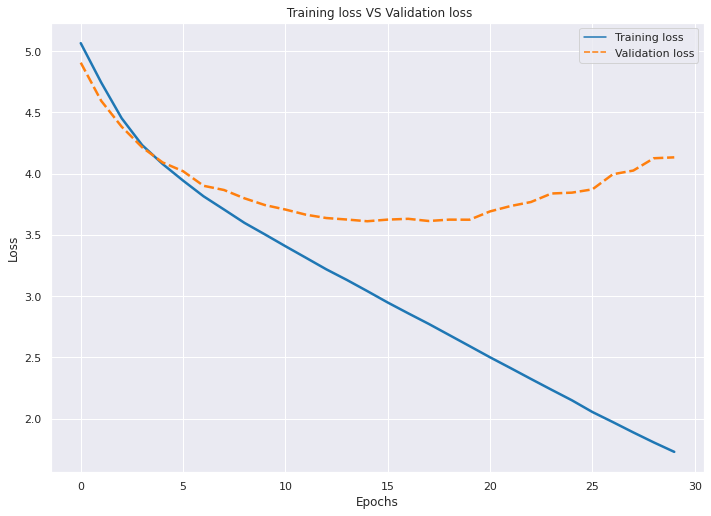

In [ ]:
import seaborn as sns
import pandas as pd
data = pd.DataFrame({'Training loss' : merged_train_loss, 'Validation loss': merged_val_loss}, index = range(0,30,1))
# data
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(data = data, palette='tab10',linewidth=2.5).set(xlabel = 'Epochs', ylabel = 'Loss',title = " Training loss VS Validation loss" )

[Text(0, 0.5, 'accuracy'),
 Text(0.5, 0, 'Epochs'),
 Text(0.5, 1.0, ' Training Accuracy VS Validation Accuracy')]

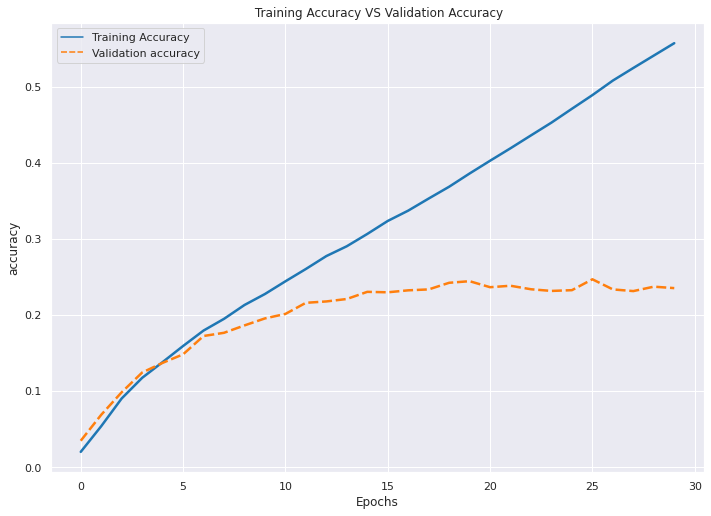

In [ ]:
import seaborn as sns
import pandas as pd
data = pd.DataFrame({'Training Accuracy' : merged_accuracy, 'Validation accuracy': merged_val_accuracy}, index = range(0,30,1))
# data
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(data = data, palette='tab10',linewidth=2.5).set(xlabel = 'Epochs', ylabel = 'accuracy',title = " Training Accuracy VS Validation Accuracy" )

#### We can observe that, starting from 15th epoch our model is getting overfitted. Lets try will lower learning rate

#### Training model with Adam optimizer with learning rate = 0.000001

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
# importing model trained for learning rate

from tensorflow.keras.models import load_model

model = load_model("/content/gdrive/MyDrive/dlproject/learningrate/vgg16_00001.h5")

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 64, 64, 64)        1792      
                                                                 
 conv2d_21 (Conv2D)          (None, 64, 64, 64)        36928     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_22 (Conv2D)          (None, 32, 32, 128)       73856     
                                                                 
 conv2d_23 (Conv2D)          (None, 32, 32, 128)       147584    
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 16, 16, 128)      0         
 2D)                                                  

In [ ]:
# Removing complete directory
# !rm -r "/content/gdrive/MyDrive/dlproject/training1"

In [ ]:
# Training for 10 more epochs
model.compile(loss = 'categorical_crossentropy',
              metrics=['accuracy'],
              optimizer= tf.keras.optimizers.Adam(learning_rate= 0.000001))


checkpoint = ModelCheckpoint("/content/gdrive/MyDrive/dlproject/training1/11_20/model-{epoch:02d}-{val_accuracy:.3f}.hdf5",
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=False,
                             mode='auto',
                             period=1,
                             )

model11_20 = model.fit(train_it,batch_size=64,
                validation_data= validation_it,
                epochs=10,
                verbose=1,
                 callbacks=[checkpoint])

# Open a file and use dump()
with open('/content/gdrive/MyDrive/dlproject/training1/10_20/model11_20.pkl', 'wb') as file:
      
    # A new file will be created
    pickle.dump(model11_20, file)

Epoch 1/10
1563/1563 [==============================] - ETA: 0s - loss: 3.2916 - accuracy: 0.2663
Epoch 00001: val_accuracy improved from -inf to 0.20990, saving model to /content/gdrive/MyDrive/dlproject/training1/11_20/model-01-0.210.hdf5
1563/1563 [==============================] - 313s 192ms/step - loss: 3.2916 - accuracy: 0.2663 - val_loss: 3.6879 - val_accuracy: 0.2099
Epoch 2/10
1563/1563 [==============================] - ETA: 0s - loss: 3.2497 - accuracy: 0.2753
Epoch 00002: val_accuracy improved from 0.20990 to 0.21820, saving model to /content/gdrive/MyDrive/dlproject/training1/11_20/model-02-0.218.hdf5
1563/1563 [==============================] - 301s 192ms/step - loss: 3.2497 - accuracy: 0.2753 - val_loss: 3.6631 - val_accuracy: 0.2182
Epoch 3/10
1563/1563 [==============================] - ETA: 0s - loss: 3.2231 - accuracy: 0.2782
Epoch 00003: val_accuracy did not improve from 0.21820
1563/1563 [==============================] - 297s 190ms/step - loss: 3.2231 - accuracy: 

FileNotFoundError: ignored

In [ ]:
model11_20
# Open a file and use dump()
with open('/content/gdrive/MyDrive/dlproject/training1/11_20/model11_20.pkl', 'wb') as file:
      
    # A new file will be created
    pickle.dump(model11_20, file)

INFO:tensorflow:Assets written to: ram://3d70644a-ee4d-4e2f-a05d-ea269fcd25f9/assets


#### Results

In [ ]:
import pickle

with open("/content/gdrive/MyDrive/dlproject/learningrate/history00001.pkl",'rb') as file:
  epoch0_10 = pickle.load(file)

with open("/content/gdrive/MyDrive/dlproject/training1/11_20/model11_20.pkl",'rb') as file:
  epoch11_20 = pickle.load(file)

# with open("/content/gdrive/MyDrive/dlproject/training/21_30/model21_30.pkl",'rb') as file:
#   epoch21_30 = pickle.load(file)

In [ ]:
val_loss0_10 = epoch0_10.history['val_loss']
val_loss11_20 = epoch11_20.history['val_loss']
# val_loss21_30 = epoch21_30.history['val_loss']/

merged_val_loss = val_loss0_10 + val_loss11_20

val_accuracy0_10 = epoch0_10.history['val_accuracy']
val_accuracy11_20 = epoch11_20.history['val_accuracy']
# val_accuracy21_30 = epoch21_30.history['val_accuracy']/

merged_val_accuracy = val_accuracy0_10 + val_accuracy11_20

In [ ]:
train_loss0_10 = epoch0_10.history['loss']
train_loss11_20 = epoch11_20.history['loss']
# train_loss21_30 = epoch21_30.history['loss']

merged_train_loss = train_loss0_10 + train_loss11_20

train_accuracy0_10 = epoch0_10.history['accuracy']
train_accuracy11_20 = epoch11_20.history['accuracy']
# train_accuracy21_30 = epoch21_30.history['accuracy']

merged_train_accuracy = train_accuracy0_10 + train_accuracy11_20

[Text(0, 0.5, 'Loss'),
 Text(0.5, 0, 'Epochs'),
 Text(0.5, 1.0, ' Training loss VS Validation loss')]

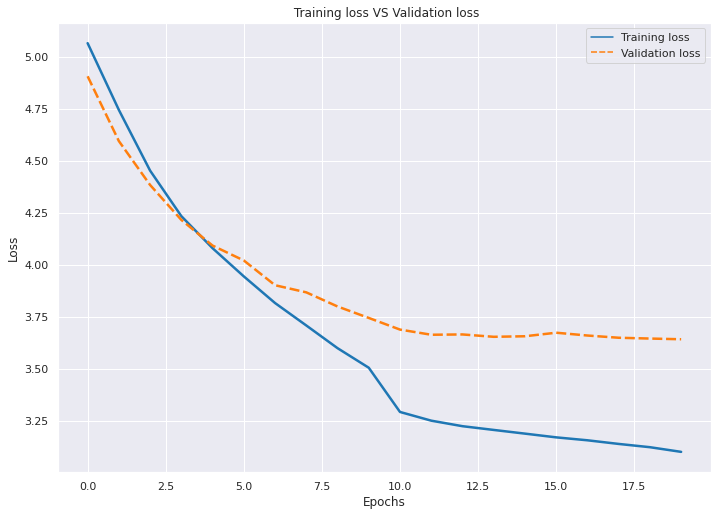

In [ ]:
import seaborn as sns
import pandas as pd
data = pd.DataFrame({'Training loss' : merged_train_loss, 'Validation loss': merged_val_loss}, index = range(0,20,1))
# data
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(data = data, palette='tab10',linewidth=2.5).set(xlabel = 'Epochs', ylabel = 'Loss',title = " Training loss VS Validation loss" )

[Text(0, 0.5, 'Accuracy'),
 Text(0.5, 0, 'Epochs'),
 Text(0.5, 1.0, ' Training accuracy VS Validation accuracy')]

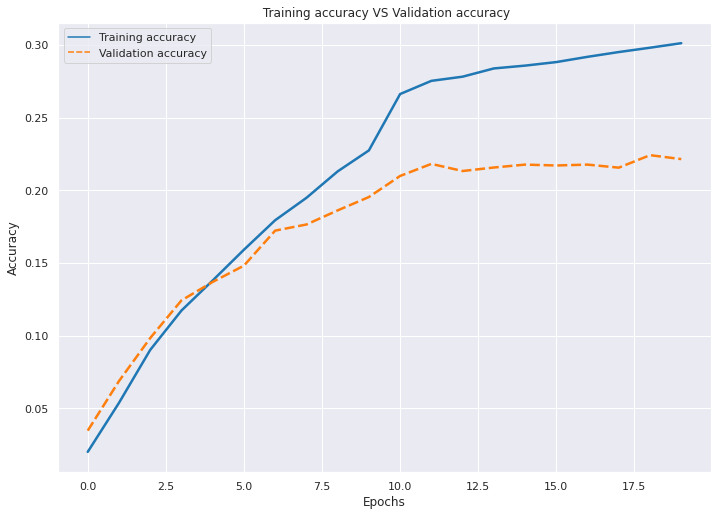

In [ ]:
import seaborn as sns
import pandas as pd
data = pd.DataFrame({'Training accuracy' : merged_train_accuracy, 'Validation accuracy': merged_val_accuracy}, index = range(0,20,1))
# data
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(data = data, palette='tab10',linewidth=2.5).set(xlabel = 'Epochs', ylabel = 'Accuracy',title = " Training accuracy VS Validation accuracy" )

#### Training model for total of 70 Epochs

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# importing model trained for learning rate

from tensorflow.keras.models import load_model

model = load_model("/content/gdrive/MyDrive/dlproject/training1/11_20/model-09-0.224.hdf5")

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 64, 64, 64)        1792      
                                                                 
 conv2d_21 (Conv2D)          (None, 64, 64, 64)        36928     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_22 (Conv2D)          (None, 32, 32, 128)       73856     
                                                                 
 conv2d_23 (Conv2D)          (None, 32, 32, 128)       147584    
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 16, 16, 128)      0         
 2D)                                                  

In [ ]:
# Training for 10 more epochs
model.compile(loss = 'categorical_crossentropy',
              metrics=['accuracy'],
              optimizer= tf.keras.optimizers.Adam(learning_rate= 0.000001))


checkpoint = ModelCheckpoint("/content/gdrive/MyDrive/dlproject/training1/21_30/model-{epoch:02d}-{val_accuracy:.3f}.hdf5",
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=False,
                             mode='auto',
                             period=1,
                             )

model21_30 = model.fit(train_it,batch_size=64,
                validation_data= validation_it,
                epochs=10,
                verbose=1,
                 callbacks=[checkpoint])

# Open a file and use dump()
with open('/content/gdrive/MyDrive/dlproject/training1/21_30/model21_30.pkl', 'wb') as file:
      
    # A new file will be created
    pickle.dump(model21_30, file)

Epoch 1/10
1563/1563 [==============================] - ETA: 0s - loss: 3.1780 - accuracy: 0.2870
Epoch 00001: val_accuracy improved from -inf to 0.21310, saving model to /content/gdrive/MyDrive/dlproject/training1/21_30/model-01-0.213.hdf5
1563/1563 [==============================] - 308s 189ms/step - loss: 3.1780 - accuracy: 0.2870 - val_loss: 3.6976 - val_accuracy: 0.2131
Epoch 2/10
1563/1563 [==============================] - ETA: 0s - loss: 3.1593 - accuracy: 0.2880
Epoch 00002: val_accuracy improved from 0.21310 to 0.21550, saving model to /content/gdrive/MyDrive/dlproject/training1/21_30/model-02-0.215.hdf5
1563/1563 [==============================] - 298s 190ms/step - loss: 3.1593 - accuracy: 0.2880 - val_loss: 3.6822 - val_accuracy: 0.2155
Epoch 3/10
1563/1563 [==============================] - ETA: 0s - loss: 3.1513 - accuracy: 0.2889
Epoch 00003: val_accuracy did not improve from 0.21550
1563/1563 [==============================] - 292s 186ms/step - loss: 3.1513 - accuracy: 

FileNotFoundError: ignored

In [ ]:
model21_30
# Open a file and use dump()
with open('/content/gdrive/MyDrive/dlproject/training1/21_30/model21_30.pkl', 'wb') as file:
      
    # A new file will be created
    pickle.dump(model21_30, file)

INFO:tensorflow:Assets written to: ram://a77d4901-1485-4ae3-9f75-1f9015829343/assets


In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# importing model trained for learning rate

from tensorflow.keras.models import load_model

model = load_model("/content/gdrive/MyDrive/dlproject/training1/21_30/model-10-0.223.hdf5")

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 64, 64, 64)        1792      
                                                                 
 conv2d_21 (Conv2D)          (None, 64, 64, 64)        36928     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_22 (Conv2D)          (None, 32, 32, 128)       73856     
                                                                 
 conv2d_23 (Conv2D)          (None, 32, 32, 128)       147584    
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 16, 16, 128)      0         
 2D)                                                  

In [ ]:
# Training for 10 more epochs
model.compile(loss = 'categorical_crossentropy',
              metrics=['accuracy'],
              optimizer= tf.keras.optimizers.Adam(learning_rate= 0.000001))


checkpoint = ModelCheckpoint("/content/gdrive/MyDrive/dlproject/training1/31_40/model-{epoch:02d}-{val_accuracy:.3f}.hdf5",
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=False,
                             mode='auto',
                             period=1,
                             )

model31_40 = model.fit(train_it,batch_size=64,
                validation_data= validation_it,
                epochs=10,
                verbose=1,
                 callbacks=[checkpoint])

# Open a file and use dump()
with open('/content/gdrive/MyDrive/dlproject/training1/31_40/model31_40.pkl', 'wb') as file:
      
    # A new file will be created
    pickle.dump(model31_40, file)

Epoch 1/10
1563/1563 [==============================] - ETA: 0s - loss: 3.0477 - accuracy: 0.3089
Epoch 00001: val_accuracy improved from -inf to 0.21980, saving model to /content/gdrive/MyDrive/dlproject/training1/31_40/model-01-0.220.hdf5
1563/1563 [==============================] - 306s 188ms/step - loss: 3.0477 - accuracy: 0.3089 - val_loss: 3.6731 - val_accuracy: 0.2198
Epoch 2/10
1563/1563 [==============================] - ETA: 0s - loss: 3.0362 - accuracy: 0.3096
Epoch 00002: val_accuracy improved from 0.21980 to 0.22410, saving model to /content/gdrive/MyDrive/dlproject/training1/31_40/model-02-0.224.hdf5
1563/1563 [==============================] - 298s 190ms/step - loss: 3.0362 - accuracy: 0.3096 - val_loss: 3.6722 - val_accuracy: 0.2241
Epoch 3/10
1563/1563 [==============================] - ETA: 0s - loss: 3.0289 - accuracy: 0.3124
Epoch 00003: val_accuracy did not improve from 0.22410
1563/1563 [==============================] - 286s 183ms/step - loss: 3.0289 - accuracy: 

In [ ]:
# Training for 10 more epochs
model.compile(loss = 'categorical_crossentropy',
              metrics=['accuracy'],
              optimizer= tf.keras.optimizers.Adam(learning_rate= 0.000001))


checkpoint = ModelCheckpoint("/content/gdrive/MyDrive/dlproject/training1/41_50/model-{epoch:02d}-{val_accuracy:.3f}.hdf5",
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=False,
                             mode='auto',
                             period=1,
                             )

model41_50 = model.fit(train_it,batch_size=64,
                validation_data= validation_it,
                epochs=10,
                verbose=1,
                 callbacks=[checkpoint])

# Open a file and use dump()
with open('/content/gdrive/MyDrive/dlproject/training1/41_50/model41_50.pkl', 'wb') as file:
      
    # A new file will be created
    pickle.dump(model41_50, file)

Epoch 1/10
1563/1563 [==============================] - ETA: 0s - loss: 2.9354 - accuracy: 0.3273
Epoch 00001: val_accuracy improved from -inf to 0.22230, saving model to /content/gdrive/MyDrive/dlproject/training1/41_50/model-01-0.222.hdf5
1563/1563 [==============================] - 291s 185ms/step - loss: 2.9354 - accuracy: 0.3273 - val_loss: 3.6869 - val_accuracy: 0.2223
Epoch 2/10
1563/1563 [==============================] - ETA: 0s - loss: 2.9190 - accuracy: 0.3299
Epoch 00002: val_accuracy improved from 0.22230 to 0.22630, saving model to /content/gdrive/MyDrive/dlproject/training1/41_50/model-02-0.226.hdf5
1563/1563 [==============================] - 291s 186ms/step - loss: 2.9190 - accuracy: 0.3299 - val_loss: 3.6815 - val_accuracy: 0.2263
Epoch 3/10
1563/1563 [==============================] - ETA: 0s - loss: 2.9134 - accuracy: 0.3316
Epoch 00003: val_accuracy improved from 0.22630 to 0.22990, saving model to /content/gdrive/MyDrive/dlproject/training1/41_50/model-03-0.230.hd

In [ ]:
# Training for 10 more epochs
model.compile(loss = 'categorical_crossentropy',
              metrics=['accuracy'],
              optimizer= tf.keras.optimizers.Adam(learning_rate= 0.000001))


checkpoint = ModelCheckpoint("/content/gdrive/MyDrive/dlproject/training1/51_60/model-{epoch:02d}-{val_accuracy:.3f}.hdf5",
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=False,
                             mode='auto',
                             period=1,
                             )

model51_60 = model.fit(train_it,batch_size=64,
                validation_data= validation_it,
                epochs=10,
                verbose=1,
                 callbacks=[checkpoint])

# Open a file and use dump()
with open('/content/gdrive/MyDrive/dlproject/training1/51_60/model51_60.pkl', 'wb') as file:
      
    # A new file will be created
    pickle.dump(model51_60, file)

Epoch 1/10
1563/1563 [==============================] - ETA: 0s - loss: 2.8225 - accuracy: 0.3477
Epoch 00001: val_accuracy improved from -inf to 0.22770, saving model to /content/gdrive/MyDrive/dlproject/training1/51_60/model-01-0.228.hdf5
1563/1563 [==============================] - 292s 186ms/step - loss: 2.8225 - accuracy: 0.3477 - val_loss: 3.6985 - val_accuracy: 0.2277
Epoch 2/10
1563/1563 [==============================] - ETA: 0s - loss: 2.8092 - accuracy: 0.3496
Epoch 00002: val_accuracy improved from 0.22770 to 0.22980, saving model to /content/gdrive/MyDrive/dlproject/training1/51_60/model-02-0.230.hdf5
1563/1563 [==============================] - 292s 187ms/step - loss: 2.8092 - accuracy: 0.3496 - val_loss: 3.6836 - val_accuracy: 0.2298
Epoch 3/10
1563/1563 [==============================] - ETA: 0s - loss: 2.8013 - accuracy: 0.3543
Epoch 00003: val_accuracy did not improve from 0.22980
1563/1563 [==============================] - 290s 185ms/step - loss: 2.8013 - accuracy: 

In [ ]:
# Training for 10 more epochs
model.compile(loss = 'categorical_crossentropy',
              metrics=['accuracy'],
              optimizer= tf.keras.optimizers.Adam(learning_rate= 0.000001))


checkpoint = ModelCheckpoint("/content/gdrive/MyDrive/dlproject/training1/61_70/model-{epoch:02d}-{val_accuracy:.3f}.hdf5",
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=False,
                             mode='auto',
                             period=1,
                             )

model61_70 = model.fit(train_it,batch_size=64,
                validation_data= validation_it,
                epochs=10,
                verbose=1,
                 callbacks=[checkpoint])

# Open a file and use dump()
with open('/content/gdrive/MyDrive/dlproject/training1/61_70/model61_70.pkl', 'wb') as file:
      
    # A new file will be created
    pickle.dump(model61_70, file)

Epoch 1/10
1563/1563 [==============================] - ETA: 0s - loss: 2.7123 - accuracy: 0.3671
Epoch 00001: val_accuracy improved from -inf to 0.22500, saving model to /content/gdrive/MyDrive/dlproject/training1/61_70/model-01-0.225.hdf5
1563/1563 [==============================] - 294s 187ms/step - loss: 2.7123 - accuracy: 0.3671 - val_loss: 3.7040 - val_accuracy: 0.2250
Epoch 2/10
1563/1563 [==============================] - ETA: 0s - loss: 2.7021 - accuracy: 0.3697
Epoch 00002: val_accuracy improved from 0.22500 to 0.22750, saving model to /content/gdrive/MyDrive/dlproject/training1/61_70/model-02-0.228.hdf5
1563/1563 [==============================] - 294s 188ms/step - loss: 2.7021 - accuracy: 0.3697 - val_loss: 3.7016 - val_accuracy: 0.2275
Epoch 3/10
1563/1563 [==============================] - ETA: 0s - loss: 2.6884 - accuracy: 0.3733
Epoch 00003: val_accuracy improved from 0.22750 to 0.23060, saving model to /content/gdrive/MyDrive/dlproject/training1/61_70/model-03-0.231.hd

In [ ]:
# Training for 10 more epochs
model.compile(loss = 'categorical_crossentropy',
              metrics=['accuracy'],
              optimizer= tf.keras.optimizers.Adam(learning_rate= 0.000001))


checkpoint = ModelCheckpoint("/content/gdrive/MyDrive/dlproject/training1/71_80/model-{epoch:02d}-{val_accuracy:.3f}.hdf5",
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=False,
                             mode='auto',
                             period=1,
                             )

model71_80 = model.fit(train_it,batch_size=64,
                validation_data= validation_it,
                epochs=10,
                verbose=1,
                 callbacks=[checkpoint])

# Open a file and use dump()
with open('/content/gdrive/MyDrive/dlproject/training1/71_80/model71_80.pkl', 'wb') as file:
      
    # A new file will be created
    pickle.dump(model71_80, file)

Epoch 1/10
1502/1563 [===========================>..] - ETA: 10s - loss: 2.6093 - accuracy: 0.3877

### Results after training the model for 70 epochs 

In [ ]:
# Importing model history from google drive
import pickle

with open("/content/gdrive/MyDrive/dlproject/learningrate/history00001.pkl",'rb') as file:
  epoch0_10 = pickle.load(file)

with open("/content/gdrive/MyDrive/dlproject/training1/11_20/model11_20.pkl",'rb') as file:
  epoch11_20 = pickle.load(file)

with open("/content/gdrive/MyDrive/dlproject/training1/21_30/model21_30.pkl",'rb') as file:
  epoch21_30 = pickle.load(file)

with open("/content/gdrive/MyDrive/dlproject/training1/31_40/model31_40.pkl",'rb') as file:
  epoch31_40 = pickle.load(file)

with open("/content/gdrive/MyDrive/dlproject/training1/41_50/model41_50.pkl",'rb') as file:
  epoch41_50 = pickle.load(file)

with open("/content/gdrive/MyDrive/dlproject/training1/51_60/model51_60.pkl",'rb') as file:
  epoch51_60 = pickle.load(file)

with open("/content/gdrive/MyDrive/dlproject/training1/61_70/model61_70.pkl",'rb') as file:
  epoch61_70 = pickle.load(file)

In [ ]:
val_loss0_10 = epoch0_10.history['val_loss']
val_loss11_20 = epoch11_20.history['val_loss']
val_loss21_30 = epoch21_30.history['val_loss']
val_loss31_40 = epoch31_40.history['val_loss']
val_loss41_50 = epoch41_50.history['val_loss']
val_loss51_60 = epoch51_60.history['val_loss']
val_loss61_70 = epoch61_70.history['val_loss']
# val_loss21_30 = epoch21_30.history['val_loss']/

merged_val_loss = val_loss0_10 + val_loss11_20 + val_loss21_30 + val_loss31_40 + val_loss41_50 + val_loss51_60 + val_loss61_70

val_accuracy0_10 = epoch0_10.history['val_accuracy']
val_accuracy11_20 = epoch11_20.history['val_accuracy']
val_accuracy21_30 = epoch21_30.history['val_accuracy']
val_accuracy31_40 = epoch31_40.history['val_accuracy']
val_accuracy41_50 = epoch41_50.history['val_accuracy']
val_accuracy51_60 = epoch51_60.history['val_accuracy']
val_accuracy61_70 = epoch61_70.history['val_accuracy']
# val_accuracy21_30 = epoch21_30.history['val_accuracy']/

merged_val_accuracy = val_accuracy0_10 + val_accuracy11_20 + val_accuracy21_30 + val_accuracy31_40 + val_accuracy41_50 + val_accuracy51_60 + val_accuracy61_70

In [ ]:
train_loss0_10 = epoch0_10.history['loss']
train_loss11_20 = epoch11_20.history['loss']
train_loss21_30 = epoch21_30.history['loss']
train_loss31_40 = epoch31_40.history['loss']
train_loss41_50 = epoch41_50.history['loss']
train_loss51_60 = epoch51_60.history['loss']
train_loss61_70 = epoch61_70.history['loss']
# train_loss21_30 = epoch21_30.history['loss']

merged_train_loss = train_loss0_10 + train_loss11_20 + train_loss21_30 + train_loss31_40 + train_loss41_50 + train_loss51_60 + train_loss61_70

train_accuracy0_10 = epoch0_10.history['accuracy']
train_accuracy11_20 = epoch11_20.history['accuracy']
train_accuracy21_30 = epoch21_30.history['accuracy']
train_accuracy31_40 = epoch31_40.history['accuracy']
train_accuracy41_50 = epoch41_50.history['accuracy']
train_accuracy51_60 = epoch51_60.history['accuracy']
train_accuracy61_70 = epoch61_70.history['accuracy']
# train_accuracy21_30 = epoch21_30.history['accuracy']

merged_train_accuracy = train_accuracy0_10 + train_accuracy11_20 + train_accuracy21_30 + train_accuracy31_40 + train_accuracy41_50 + train_accuracy51_60 + train_accuracy61_70

[Text(0, 0.5, 'Loss'),
 Text(0.5, 0, 'Epochs'),
 Text(0.5, 1.0, ' Training loss VS Validation loss')]

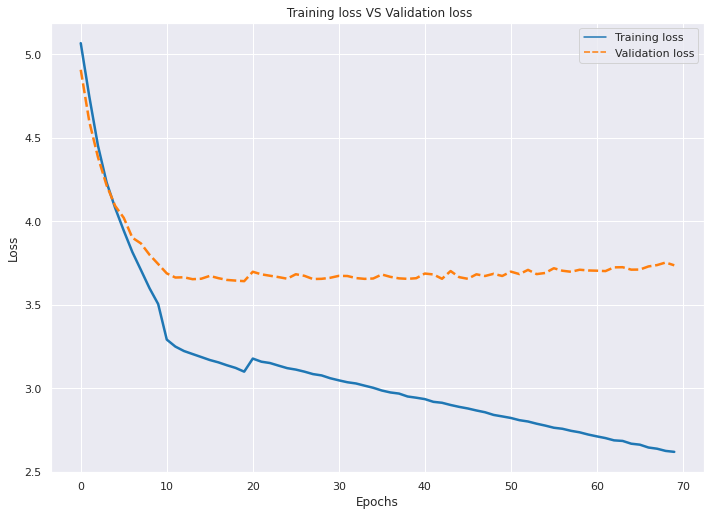

In [ ]:
import seaborn as sns
import pandas as pd
data = pd.DataFrame({'Training loss' : merged_train_loss, 'Validation loss': merged_val_loss}, index = range(0,70,1))
# data
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(data = data, palette='tab10',linewidth=2.5).set(xlabel = 'Epochs', ylabel = 'Loss',title = " Training loss VS Validation loss" )

[Text(0, 0.5, 'Accuracy'),
 Text(0.5, 0, 'Epochs'),
 Text(0.5, 1.0, ' Training accuracy VS Validation accuracy')]

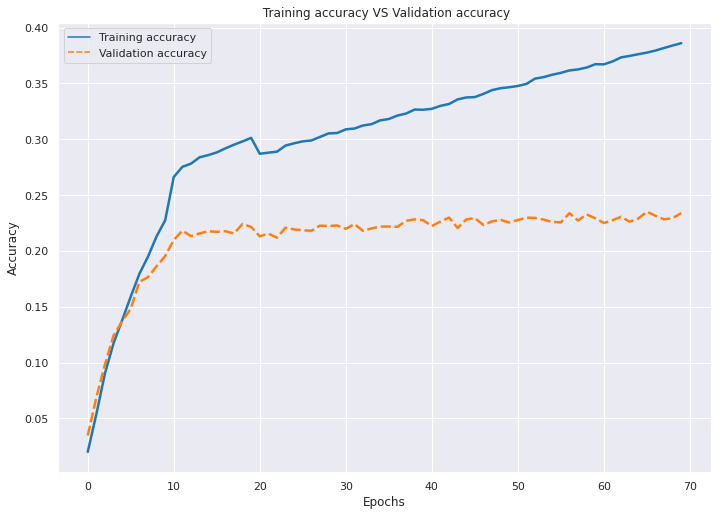

In [ ]:
import seaborn as sns
import pandas as pd
data = pd.DataFrame({'Training accuracy' : merged_train_accuracy, 'Validation accuracy': merged_val_accuracy}, index = range(0,70,1))
# data
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(data = data, palette='tab10',linewidth=2.5).set(xlabel = 'Epochs', ylabel = 'Accuracy',title = " Training accuracy VS Validation accuracy" )

### Predicting the test images 

In [ ]:
from google.colab import drive
drive._mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# importing trained model

from tensorflow.keras.models import load_model
model = load_model("/content/gdrive/MyDrive/dlproject/training1/61_70/model-06-0.235.hdf5")

In [ ]:
# Method for predicting the image and returns the class name

def predict(path):
  path = "/content/tiny-imagenet-200/test/images/" + path
  # print(path)
  img = cv2.imread(path , -1)
  img = cv2.resize(img,(64,64))
  img = np.reshape(img,[1,64,64,3])
  softmax_output = model.predict(img)
  output = softmax_output.argmax(axis= -1)
  return labels[int(output)]

In [ ]:
images_list = sorted(os.listdir("/content/tiny-imagenet-200/test/images"))
# print(sorted(images_list))

In [ ]:
output_csv = dict()
error = []
for path in images_list:
  image_name = path[:-5]
  try:
    output_csv[image_name] = predict(path)
  except:
    output_csv[image_name] = "-"
    error.append(image_name)

In [ ]:
len(error)

189

##### There are 189 black and white images which are not taken for predicting the output class label

#### Exporting the test image name and corresponding predicted label into output.csv file

In [ ]:
import csv
file = open("output.csv", "w")

writer = csv.writer(file)
for key, value in output_csv.items():
    writer.writerow([key, value])

file.close()